In [7]:
import geopandas
from ipyleaflet import Map, Marker, Popup, basemaps, GeoData, MarkerCluster, FullScreenControl, LayersControl, basemap_to_tiles

import copy

%matplotlib inline
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib.dates import DateFormatter

# NWIS API library
import dataretrieval.nwis as nwis

In [8]:
# Filesystem
import sys
sys.path.append("../../")

In [24]:
!pip install tensorflow

Parameters:

Temperature, air, °C : 00010

Nitrate plus nitrite, water, in situ, milligrams per liter as nitrogen: 99133

Dissolved oxygen, water, unfiltered, milligrams per liter: 00300

Discharge, cubic feed per second : 00060

In Washington State:

Multiple sites have temperature, DO data, and discharge
One site has nitrite/nitrate data (12473503)
No phosphate/phosphorus data

In [25]:
from tensorflow import keras

ModuleNotFoundError: No module named 'tensorflow'

In [9]:
PARAMETERS = ["00095","00060","00010","99133","00300"]
RINGOLD_START_DATE = "2019-04-20"
END_DATE = "2021-07-19"

In [10]:
# ringold_iv = nwis.get_record(sites="12473503", service="iv", parameterCd = PARAMETERS,start = RINGOLD_START_DATE,end = END_DATE)
# ringold_dv = nwis.get_record(sites="12473503", service="dv", parameterCd = PARAMETERS,start = RINGOLD_START_DATE,end = END_DATE)

%store -r ringold_iv
%store -r ringold_dv

In [11]:
ringold_iv

,00010,00010_cd,site_no,00060,00060_cd,00095,00095_cd,00300,00300_cd,99133,99133_cd
datetime,,,,,,,,,,,
2019-04-20T00:00:00.000-07:00,15.9,A,12473503,19.5,P,557.0,A,9.8,A,NaN,NaN
2019-04-20T00:15:00.000-07:00,15.8,A,12473503,19.5,P,555.0,A,9.8,A,NaN,NaN
2019-04-20T00:30:00.000-07:00,15.6,A,12473503,19.0,P,554.0,A,9.9,A,NaN,NaN
2019-04-20T00:45:00.000-07:00,15.5,A,12473503,18.4,P,552.0,A,9.9,A,NaN,NaN
2019-04-20T01:00:00.000-07:00,15.4,A,12473503,18.4,P,552.0,A,9.9,A,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-19T22:45:00.000-07:00,NaN,NaN,12473503,51.1,P,NaN,NaN,NaN,NaN,3.2,P
2021-07-19T23:00:00.000-07:00,NaN,NaN,12473503,51.1,P,NaN,NaN,NaN,NaN,3.2,P
2021-07-19T23:15:00.000-07:00,NaN,NaN,12473503,52.0,P,NaN,NaN,NaN,NaN,3.3,P


In [12]:
# Copy raw RINGOLD IV dataset from NWIS
ringold_iv_final = copy.deepcopy(ringold_iv)

# Isolate the target parameters
ringold_iv_final = ringold_iv_final[PARAMETERS]

# Convert datestamp objects to datetime index (Austin's method)
ringold_iv_final.reset_index(inplace = True)
ringold_iv_final['datetime'] = pd.to_datetime(ringold_iv_final['datetime'])
ringold_iv_final.set_index('datetime', inplace = True)



# Remove all impossible values by settingto NaN
for column in ringold_iv_final:
    ringold_iv_final[ringold_iv_final[column] < 0] = np.nan

# Prepare for plotting - rename values
IV_NAMES = {
    '00095':'Specific conductance at 25 deg. C [microsiemens/cm]',
    '00300':'Dissolved oxygen [mg/L]',
    '99133':'Nitrate & nitrite [mg/L]',
    '00010':'Temperature [deg C]',
    '00060':'Discharge [ft^3/sec]'
}
IV_NAMES_LIST = list(IV_NAMES.values())
ringold_iv_final.rename(columns = IV_NAMES, inplace = True)

# Print
display(ringold_iv_final)

,Specific conductance at 25 deg. C [microsiemens/cm],Discharge [ft^3/sec],Temperature [deg C],Nitrate & nitrite [mg/L],Dissolved oxygen [mg/L]
datetime,,,,,
2019-04-20 00:00:00-07:00,557.0,19.5,15.9,NaN,9.8
2019-04-20 00:15:00-07:00,555.0,19.5,15.8,NaN,9.8
2019-04-20 00:30:00-07:00,554.0,19.0,15.6,NaN,9.9
2019-04-20 00:45:00-07:00,552.0,18.4,15.5,NaN,9.9
2019-04-20 01:00:00-07:00,552.0,18.4,15.4,NaN,9.9
...,...,...,...,...,...
2021-07-19 22:45:00-07:00,NaN,51.1,NaN,3.2,NaN
2021-07-19 23:00:00-07:00,NaN,51.1,NaN,3.2,NaN
2021-07-19 23:15:00-07:00,NaN,52.0,NaN,3.3,NaN


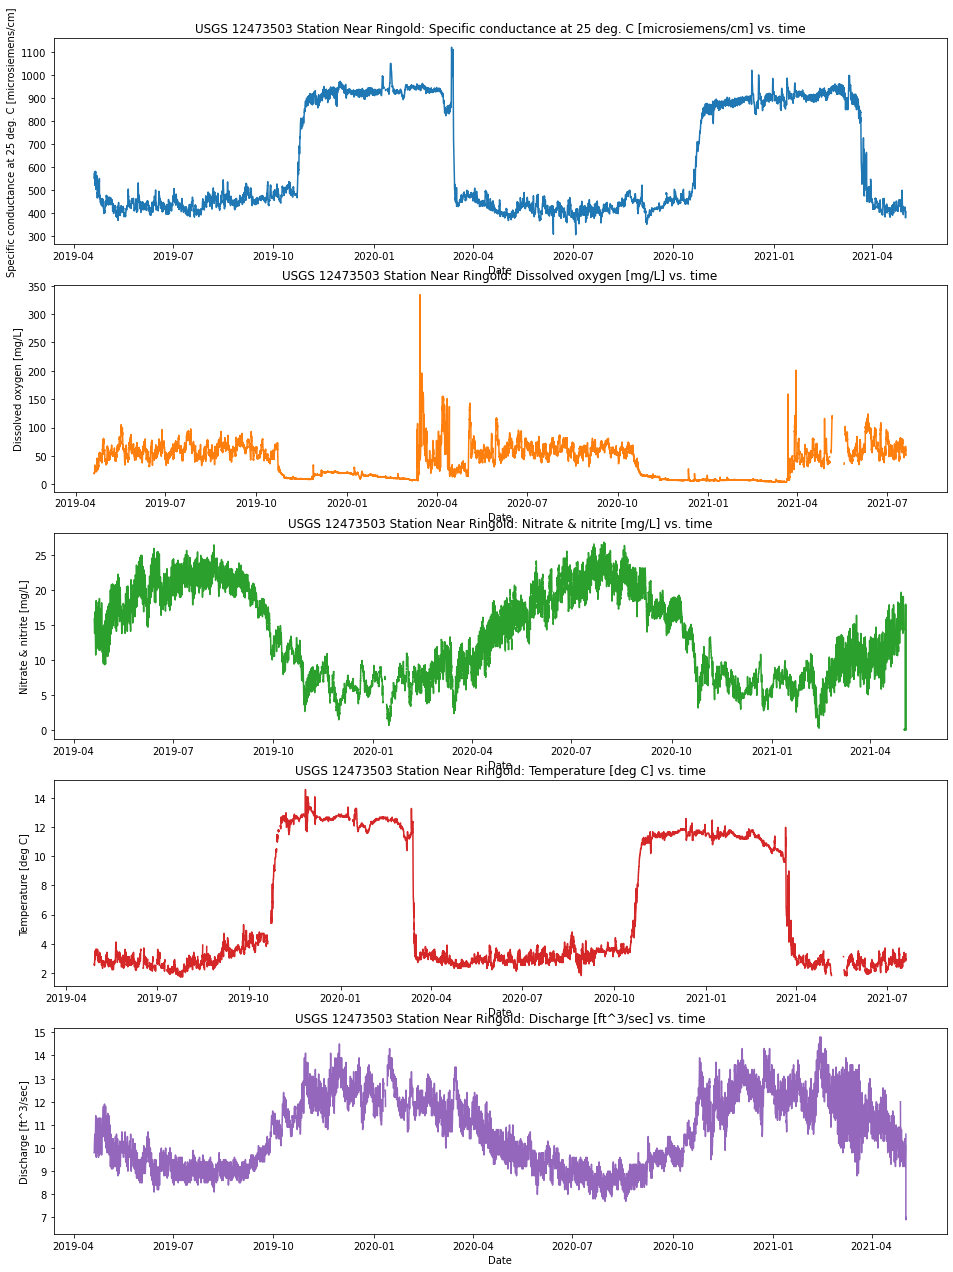

In [13]:
plotiv = ringold_iv_final.plot(subplots = True, legend=False,figsize=(16,22), xlabel='Date', sharex=False, sharey=False)

for subplotIndex in range(len(plotiv)):
    plotiv[subplotIndex].set_ylabel(IV_NAMES_LIST[subplotIndex])
    plotiv[subplotIndex].set_title("USGS 12473503 Station Near Ringold: " + IV_NAMES_LIST[subplotIndex] + " vs. time")

Text(0.5, 1.0, 'Precipitation, in. vs time')

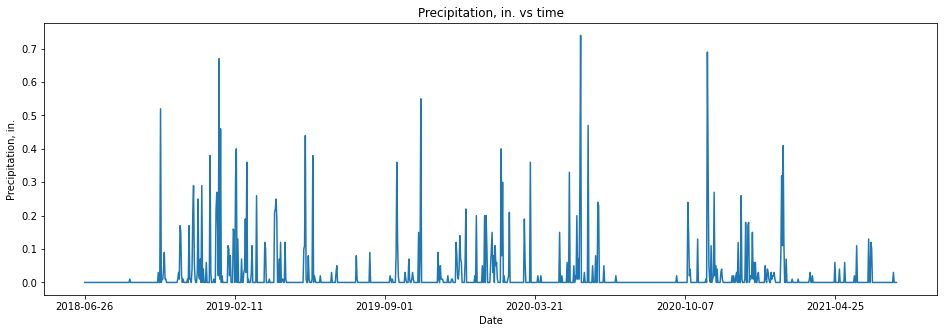

In [14]:
NOAA_DATA = pd.read_csv("noaa_station_data.csv")
NOAA_DATA = NOAA_DATA.set_index('DATE')
precip_plot = NOAA_DATA[["PRCP"]].plot(figsize=(16,5),legend=False)
precip_plot.set_xlabel("Date")
precip_plot.set_ylabel("Precipitation, in.")
precip_plot.set_title("Precipitation, in. vs time")

In [15]:
KIONA_START_DATE = '2018-06-26'
# kiona_iv = nwis.get_record(sites="12510500",service="iv", parameterCd = PARAMETERS, start = KIONA_START_DATE, end = END_DATE)
# kiona_dv = nwis.get_record(sites="12510500",service="dv", parameterCd = PARAMETERS, start = KIONA_START_DATE, end = END_DATE)

%store -r kiona_iv
%store -r kiona_dv

In [16]:
# Copy raw KIONA IV dataset from NWIS
kiona_iv_final = copy.deepcopy(kiona_iv)

# Isolate the target parameters
kiona_iv_final = kiona_iv_final[PARAMETERS]

# Remove all impossible values by setting the data to its positive values
for column in kiona_iv_final:
    kiona_iv_final[kiona_iv_final[column] < 0] = np.nan

# Print
display(kiona_iv_final)

# Prepare for plotting - rename values (dictionary already defined in Ringold method)
kiona_iv_final.rename(columns = IV_NAMES, inplace = True)

# Convert datestamp objects to datetime index (Austin's method)
kiona_iv_final.reset_index(inplace = True)
kiona_iv_final['datetime'] = pd.to_datetime(kiona_iv_final['datetime'])
kiona_iv_final.set_index('datetime', inplace = True)

,00095,00060,00010,99133,00300
datetime,,,,,
2018-06-26T00:00:00.000-07:00,NaN,905.0,NaN,NaN,NaN
2018-06-26T00:15:00.000-07:00,NaN,905.0,NaN,NaN,NaN
2018-06-26T00:30:00.000-07:00,NaN,905.0,NaN,NaN,NaN
2018-06-26T00:45:00.000-07:00,NaN,905.0,NaN,NaN,NaN
2018-06-26T01:00:00.000-07:00,NaN,894.0,NaN,NaN,NaN
...,...,...,...,...,...
2021-07-19T22:45:00.000-07:00,NaN,NaN,NaN,NaN,NaN
2021-07-19T23:00:00.000-07:00,NaN,NaN,NaN,NaN,NaN
2021-07-19T23:15:00.000-07:00,NaN,NaN,NaN,NaN,NaN


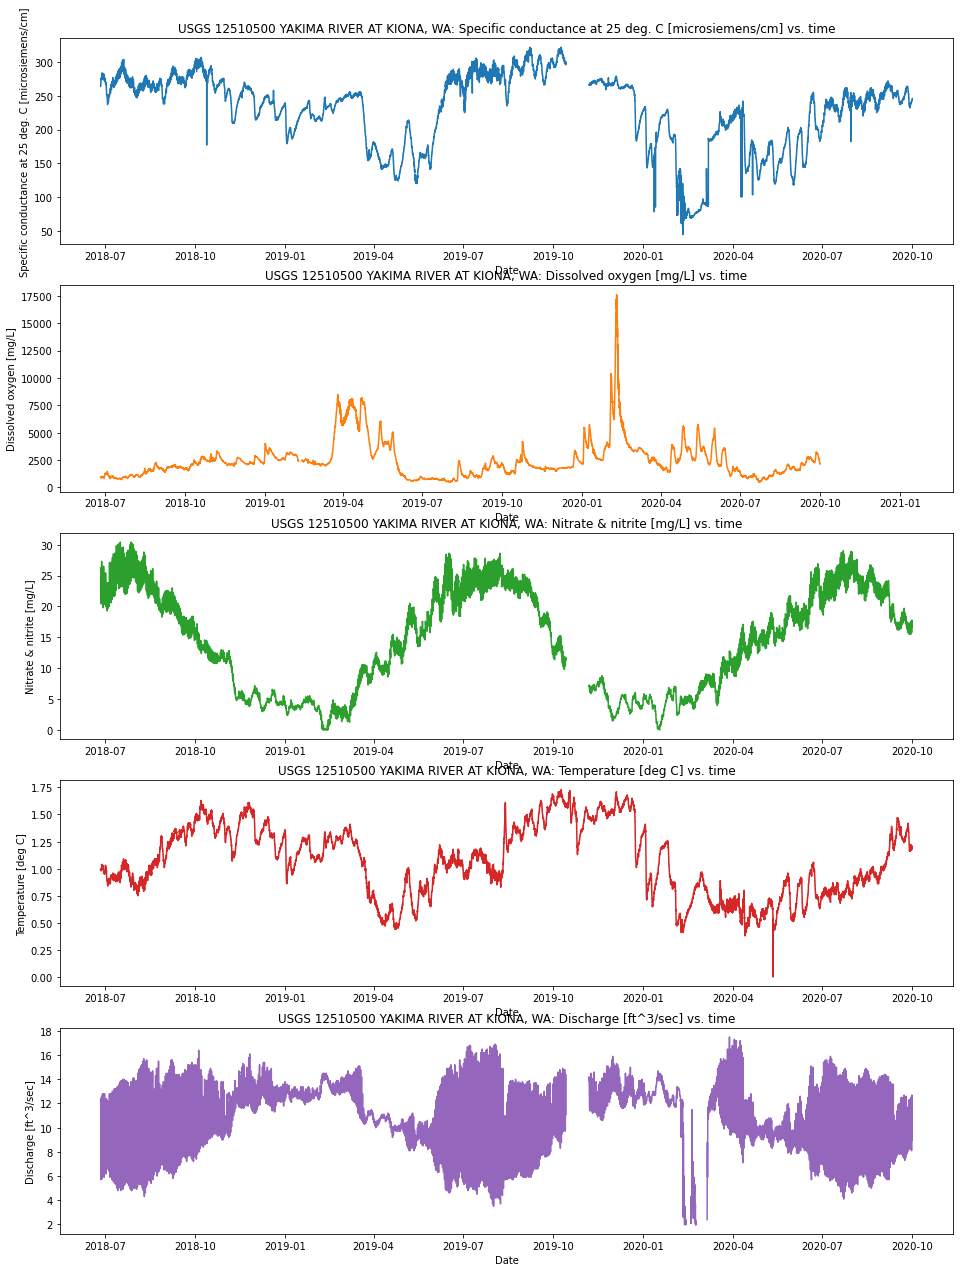

In [17]:
# Graphing
kionaplot = kiona_iv_final.plot(subplots = True, legend=False,figsize=(16,22), xlabel='Date', sharex=False, sharey=False)

for subplotIndex in range(len(kionaplot)):
    kionaplot[subplotIndex].set_ylabel(IV_NAMES_LIST[subplotIndex])
    kionaplot[subplotIndex].set_title("USGS 12510500 YAKIMA RIVER AT KIONA, WA: " + IV_NAMES_LIST[subplotIndex] + " vs. time")

Text(0, 0.5, 'Precipitation, in.')

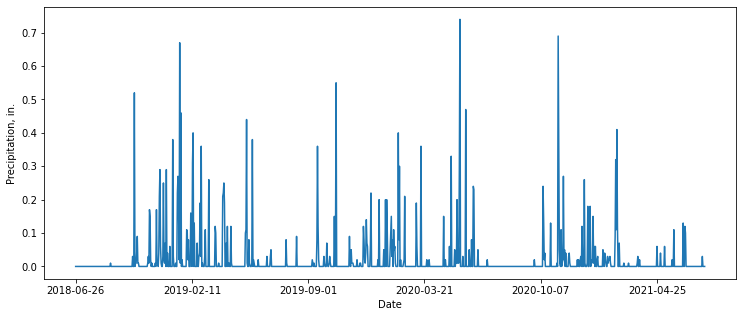

In [18]:
precip_plot = NOAA_DATA[["PRCP"]].plot(figsize=(12.4,5),legend=False)
precip_plot.set_xlabel("Date")
precip_plot.set_ylabel("Precipitation, in.")

In [19]:
# Discharge [ft^3/sec]	Temperature [deg C]	Dissolved oxygen [mg/L]	Nitrate & nitrite [mg/L]
kiona_iv_toPlot.plot(x="Discharge [ft^3/sec]", y="Temperature [deg C]",kind='scatter',figsize=(10,6))
kiona_iv_toPlot.plot(x="Discharge [ft^3/sec]", y="Dissolved oxygen [mg/L]",kind='scatter',figsize=(10,6))
kiona_iv_toPlot.plot(x="Discharge [ft^3/sec]", y="Nitrate & nitrite [mg/L]",kind='scatter',figsize=(10,6))

NameError: name 'kiona_iv_toPlot' is not defined

In [ ]:
nwis.get_info(sites=['12473503','12510500'])[0]

In [ ]:
m = Map(center=(47,-120), zoom=7)

m.add_layer(Marker(title='SCBID WB 5 WASTEWAY NEAR MOUTH NEAR RINGOLD,WA',location=(46.536522,-119.280069),rise_on_hover = True, draggable = False))
m.add_layer(Marker(title='YAKIMA RIVER AT KIONA, WA',location = (46.253467,-119.478079),rise_on_hover = True, draggable = False))
m.add_layer(Marker(title='NOAA STATION - ICE HARBOR DAM',location = (46.2447,-118.8786),rise_on_hover = True, draggable = False))

basemap1 = basemap_to_tiles(basemaps.Esri.WorldImagery)
m.add_layer(basemap1)

display(m)